In [1]:
# Multi-Agent Conversation to Play Chess Game!
# Diego Gosmar 2024

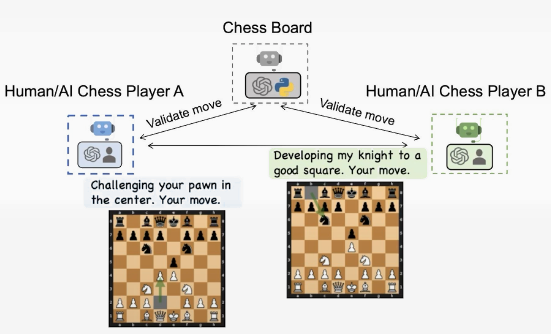

In [2]:
from IPython.display import Image
Image(filename="./images/chess.png")

In [3]:
import os
from autogen import AssistantAgent, UserProxyAgent
from autogen import ConversableAgent
import pprint

In [4]:
# Player 1 (GPT-4o-mini)
llm_config = {"model": "gpt-4o-mini", "api_key": os.environ["OPENAI_API_KEY"]}
# Player 2 (GPT-3.5-trubo)
llm_config_35 = {"model": "gpt-3.5-turbo", "api_key": os.environ["OPENAI_API_KEY"]}

In [5]:
import chess
import chess.svg
from typing_extensions import Annotated

In [6]:
board = chess.Board()

In [7]:
made_move = False

In [8]:
# Define Chess move

In [9]:
def get_legal_moves(
    
) -> Annotated[str, "A list of legal moves in UCI format"]:
    return "Possible moves are: " + ",".join(
        [str(move) for move in board.legal_moves]
    )

In [10]:
def make_move(
    move: Annotated[str, "A move in UCI format."]
) -> Annotated[str, "Result of the move."]:
    move = chess.Move.from_uci(move)
    board.push_uci(str(move))
    global made_move
    made_move = True
    
    # Display the board.
    display(
        chess.svg.board(
            board,
            arrows=[(move.from_square, move.to_square)],
            fill={move.from_square: "gray"},
            size=200
        )
    )
    
    # Get the piece name.
    piece = board.piece_at(move.to_square)
    piece_symbol = piece.unicode_symbol()
    piece_name = (
        chess.piece_name(piece.piece_type).capitalize()
        if piece_symbol.isupper()
        else chess.piece_name(piece.piece_type)
    )
    return f"Moved {piece_name} ({piece_symbol}) from "\
    f"{chess.SQUARE_NAMES[move.from_square]} to "\
    f"{chess.SQUARE_NAMES[move.to_square]}."

In [11]:
# Player white agent (GPT-4o-mini)
player_white = ConversableAgent(
    name="Player White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

In [12]:
# Player black agent (GPT-3.5)
player_black = ConversableAgent(
    name="Player Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config_35,
)

In [13]:
# Define the Board Agent

def check_made_move(msg):
    global made_move
    if made_move:
        made_move = False
        return True
    else:
        return False
    
board_proxy = ConversableAgent(
    name="Board Proxy",
    llm_config=False,
    is_termination_msg=check_made_move,
    default_auto_reply="Please make a move.",
    human_input_mode="NEVER",
)

In [14]:
# Register the tools (moves) for the agents

from autogen import register_function

for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )
    
    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

/Users/diego.gosmar/anaconda3/lib/python3.11/site-packages/autogen/agentchat/conversable_agent.py:2410: UserWarning: Function 'get_legal_moves' is being overridden.
  warnings.warn(f"Function '{name}' is being overridden.", UserWarning)
/Users/diego.gosmar/anaconda3/lib/python3.11/site-packages/autogen/agentchat/conversable_agent.py:2410: UserWarning: Function 'make_move' is being overridden.
  warnings.warn(f"Function '{name}' is being overridden.", UserWarning)


In [15]:
player_black.llm_config["tools"]

[{'type': 'function',
  'function': {'description': 'Get legal moves.',
   'name': 'get_legal_moves',
   'parameters': {'type': 'object', 'properties': {}, 'required': []}}},
 {'type': 'function',
  'function': {'description': 'Call this tool to make a move.',
   'name': 'make_move',
   'parameters': {'type': 'object',
    'properties': {'move': {'type': 'string',
      'description': 'A move in UCI format.'}},
    'required': ['move']}}}]

In [16]:
# Register the nested chat conversation patterns
# Each player agent will have a nested chat with the board proxy agent to make moves on the chess board.

In [17]:
player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
        }
    ],
)

In [18]:
# Adding a fun chitchat to the game!

In [19]:
player_white = ConversableAgent(
    name="Player White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move. "
    "After a move is made, chitchat to make the game fun.",
    llm_config=llm_config,
)

In [20]:
player_black = ConversableAgent(
    name="Player Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves(), to get a list of legal moves. "
    "Then call make_move(move) to make a move. "
    "After a move is made, chitchat to make the game fun.",
    llm_config=llm_config,
)

In [21]:
for caller in [player_white, player_black]:
    register_function(
        get_legal_moves,
        caller=caller,
        executor=board_proxy,
        name="get_legal_moves",
        description="Get legal moves.",
    )

    register_function(
        make_move,
        caller=caller,
        executor=board_proxy,
        name="make_move",
        description="Call this tool to make a move.",
    )

player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_white,
            "summary_method": "last_msg",
            "silent": True,
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            "sender": board_proxy,
            "recipient": player_black,
            "summary_method": "last_msg",
            "silent": True,
        }
    ],
)

Player Black (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


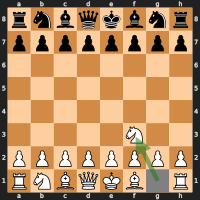


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

I've just moved my knight to f3! It's a solid start. Your move! How do you plan to respond?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


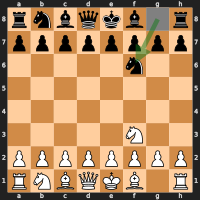


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

I've moved my knight to f6! It's a classic response, preparing to control the center. Your knight on f3 is looking strong, though! What will you do next?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


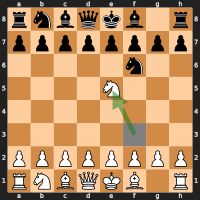


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

I've boldly moved my knight from f3 to e5, placing it right in the heart of the board! It'll be an interesting battle for central control. How will you respond to my aggressive stance? 🥳

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


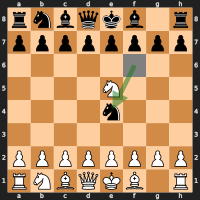


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

I've countered your bold knight move by bringing my knight from f6 to e4! Now we both have a piece in the center. This is shaping up to be quite an exciting battle for control! What's your next move? 🥳♞

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


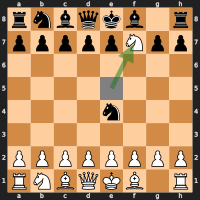


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

I’ve just moved my knight from e5 to f7, capturing your knight! 🥳 The center is getting even more thrilling. The battle unfolds as the board gets filled with tension. How will you respond? ♟️🔥

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


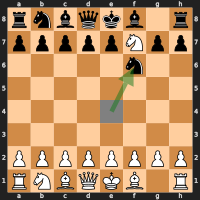


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

I've moved my knight from e4 to f6, challenging your knight and trying to regain some control in the center! The tension is palpable, and I'm sure you're ready with your next move. What will it be? The battlefield waits! ♟️⚔️

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


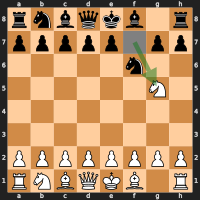


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

I’ve decided to move my knight from f7 to g5, aiming to put pressure on the center and eyeing some potential attacks! The stage grows ever more intense, wouldn't you say? Your knight may be in a bit of a pickle now! How will you respond? 🐴✨

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


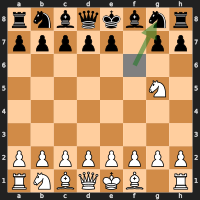


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

Aha! I see you’re making bold moves with that knight. I’ve decided to retreat my knight from f6 to g8, keeping the defense strong and maintaining my position. The board is heating up, and the pressure is building! What’s your next plan? 🌪️♞✨

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


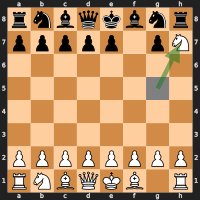


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

I've just moved my knight from g5 to h7, making sure it's snugly positioned and ready to leap into action! 🏇💨 It looks like your defensive strategy is solid, but I've got some tricks up my sleeve. What’s your next move? I can feel the tension in the air! 🎭♟️✨

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


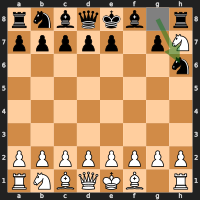


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

I've just shifted my knight from g8 to h6! 🐴🔄 It's now eyeing your pieces carefully, ready to join the fray! The battlefield is heating up, and I'm curious to see where your next move takes us! What's brewing in that strategic mind of yours? 🔍♟️✨

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


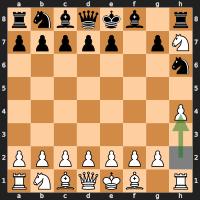


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

I decided to push my pawn from h2 to h4! 🚀 It's making a bold advance, ready to challenge your knight and support my position on the board. What's your next move? The tension is rising, and I can almost hear the chess pieces whispering strategies! 🥳♟️✨

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


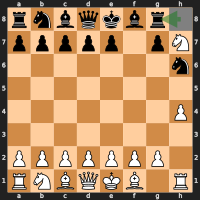


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

I've repositioned my rook from h8 to g8, bringing it into action on the g-file! I see your pawn push on h4; it's going to be an interesting challenge. The battlefield is heating up! What's your next move, oh bold strategist? 🎉♟️🔥

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


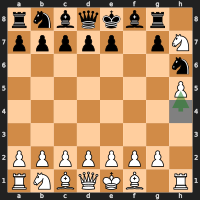


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

I boldly pushed my pawn from h4 to h5! The h-file is getting crowded now! Your rook on g8 better stay alert, as I plan to apply more pressure. What will you do next in this fiery dance of strategy? 🔥♙✨

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


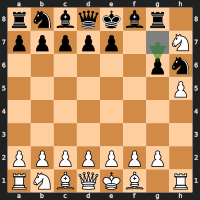


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

I've just nudged my pawn from g7 to g6! The tension is rising on the board. Your h-pawn is looking a bit lonely now. What do you think? Ready to keep the pressure on or maybe shift gears? The dance continues! 💃♟️✨

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


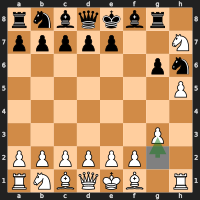


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

I see you've made your move with g7-g6! I've decided to support my h-pawn's journey by moving my pawn from g2 to g3. Now the h-pawn has some company! 

The board's getting spicy! What are you thinking for your next move? The dance of strategy continues! 💃♟️✨

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


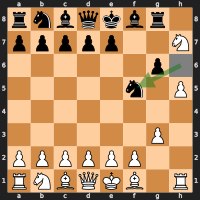


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

I've gracefully moved my knight from h6 to f5! 🌟 Now it's positioned centrally, ready to jump into action. How do you like that little maneuver? The board is heating up, and I'm curious about your next move! Let’s keep this thrilling game going! 💥♟️🕺

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


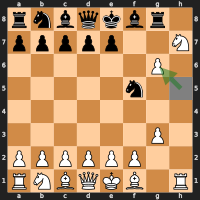


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

I just moved my pawn from h5 to g6! 🚀 It's now threatening your knight, and things are definitely heating up on the board! What's your next move? This dance of chess is only getting more exciting! 🔥♟️💃

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


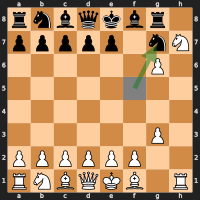


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

I just moved my knight from f5 to g7! 🐴 Now your pawn is in check! Looks like the tides are turning in my favor! How will you respond to this knightly challenge? Let's keep the fun going! 🎉♟️

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


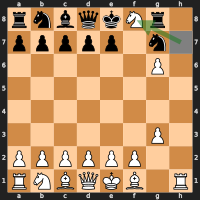


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

I have moved my knight from h7 to f8, blocking the check! 🛡️ The battle rages on! Your knight is a formidable opponent, but I won’t back down easily. What will your next move be, my clever challenger? Let's keep the excitement going! 🎉♟️

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


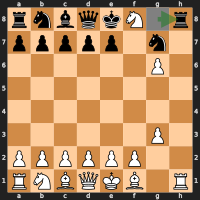


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

Ah, the rook takes its stance on h8! 🏰 Now, my formidable castle is looming, ready to join the fray. The battlefield is electric with tension! ⚡ What's your next move, brave opponent? The game just keeps getting better! 🎉♟️

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


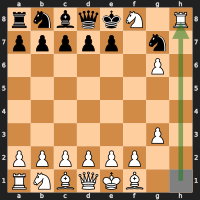


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

Behold! My rook has gallantly charged to h8, joining yours in a majestic showdown! 🏰 Now we have two mighty towers standing tall on the battlefield, creating an exhilarating atmosphere. 

What will your next move be, noble opponent? The thrill of the game is palpable! 🎊♟️

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


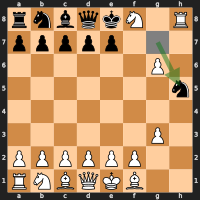


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

Aha! My knight has gracefully hopped to h5, positioning itself strategically! It's like a daring knight riding forth into the fray, ready to assist! 🏇✨

Your turn, valiant adversary! How will you respond to this bold maneuver? The tension in the air is almost electric! ⚡♟️

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


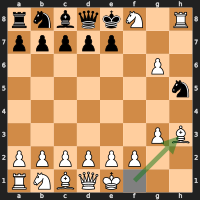


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

Ah, how splendid! My bishop has gracefully taken position on h3, aligned perfectly to gaze upon your daring knight on h5! 🌟 It's like a fine piece of artwork on the chessboard, ready to strategize against any surprise moves you might throw my way! 

What will your next gallant move be, noble opponent? The battlefield awaits your command! ⚔️♟️

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


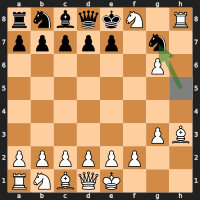


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

Ah, the knight gallops forth to g7 with a bold flourish! 🏇✨ Now it stands poised, eyes locked on your bishop, ready to challenge its elegant position. The dance of strategy continues as we both strive for supremacy on this beautiful battlefield. 

What shall be your next stroke of genius, dear challenger? The board is alive with possibilities! 🎉♟️

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


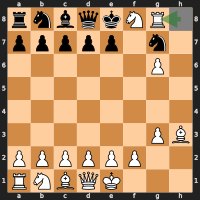


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

With a resounding clang, my rook boldly advances to g8, directly challenging your knight! The battlefield grows ever more thrilling as we maneuver our pieces into strategic positions. 🎊✨ 

What will your next move be, gallant knight? Will you retreat or stand your ground? The excitement is palpable! 🎭♟️

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


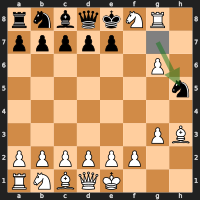


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

With a clever twist of fate, my knight leaps boldly from g7 to h5, sidestepping your rook's challenge! The dance of strategy continues as the battlefield brims with tension. 🎉 What's your next move, oh fearless opponent? The game is afoot! 🕵️‍♂️♟️

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


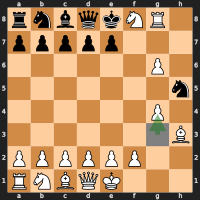


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

With a determined push, my pawn boldly advances from g3 to g4, reclaiming some space on the board! The battlefield feels even more dynamic now. Your knight may be nimble, but will it find a haven in this changing landscape? The tension mounts! 🎭 What's your next strategic maneuver? 🏰🌟

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


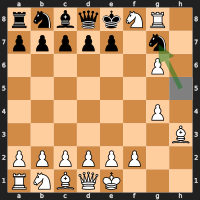


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

With a graceful leap, my knight has taken refuge on g7! It now surveys the battlefield, ready to spring into action where needed. The tension in the air is palpable—will your next move bring more surprises? Let the dance of strategy continue! 💃♟️✨

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


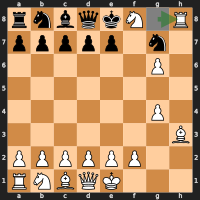


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

With a swift motion, my rook has glided from g8 to h8, fortifying my defense and standing tall against the impending challenges! The battlefield breathes anew, and the knight on g7 watches with keen interest. What will you do next? The tension is building—let’s see if you can reclaim the initiative! 🚀♟️✨

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


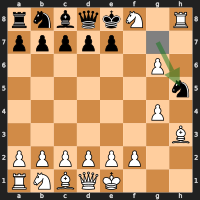


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

With a bold leap, my knight has bounded from g7 to h5! It now occupies a more aggressive stance, eyeing your pieces with a mischievous glint. The battlefield grows more intense as we maneuver our forces. What will your next move be? Let's see how this unfolds! 🔥♟️✨

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


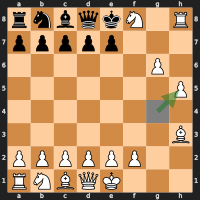


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

With a decisive motion, my pawn has advanced from g4 to h5, capturing your knight! The tension on the board escalates as I claim a piece, and your ambitious knight's leap has been thwarted. 

How will you respond to this unexpected turn of events? The dance of strategy continues! 🔥♟️✨

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


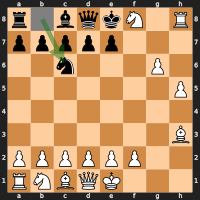


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

With a swift and calculated gesture, I summoned my knight from b8 to c6! The board pulses with renewed energy as my knight takes its position, ready to seize the initiative. 

Your pawns may think they're unstoppable, but the game is far from over! What will your next move be in this tactical showdown? ♞🔥

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


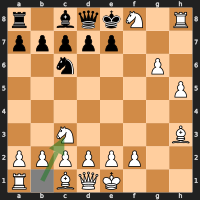


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

With a decisive move, I summoned my knight from b1 to c3! The knight stands proud in the center of the board, ready to leap into action and strategize against your advances. 

Your knight may have taken to the field, but beware—my knight has an eye on your pawns! What clever move will you play next? ♘✨

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


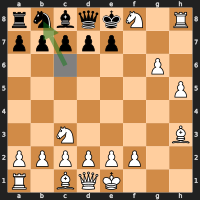


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

With a swift and stealthy maneuver, my knight has leaped to b8! It now surveys the battlefield, a sentinel watching over the pawns. Your knight may be positioned well, but my piece is ready to counter any advance you make!

What's your next move, brave knight commander? The game is heating up! ♞🔥

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


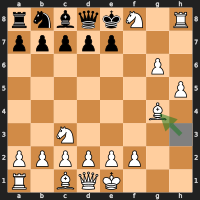


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

With a calculated and precise move, my bishop has glided from h3 to g4, positioning itself perfectly to apply pressure! The battlefield is alive with tension, and my piece now stands boldly, eyeing your knight on b8! 

What will be your next strategic gambit, oh knight strategist? Will you hold your ground, or will you pivot to a new position? Let's see what you’ve got! ⚔️✨

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


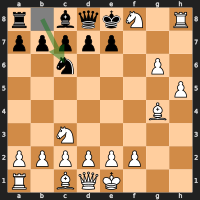


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

With a swift maneuver, my knight has leapt from b8 to c6, ready to counter your bishop's advance! The battlefield hums with anticipation as I prepare to fortify my position. 

What say you, brave bishop? Will you maintain your stance, or will you retreat in the face of this fresh threat? The game is heating up! 🏰🔥

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


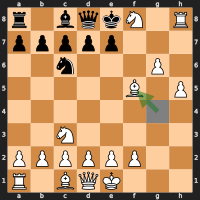


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

I have deftly advanced my bishop from g4 to f5, maintaining pressure and asserting control over the center! The battlefield feels charged as my piece stands proudly, ready to meet your knight's challenge. 

What will your next move be? The tension builds! 🌟♟️

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


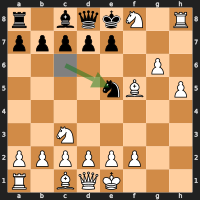


>>>>>>>> USING AUTO REPLY...
Player Black (to Player White):

I've moved my knight from c6 to e5, ready to engage in the dance of tactical maneuvers! The battlefield is heating up, and your bishop will have to navigate carefully. What's your next move? 🐴♟️✨

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION get_legal_moves...

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION make_move...


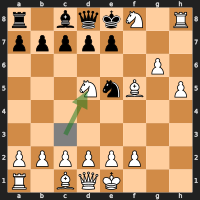


>>>>>>>> USING AUTO REPLY...
Player White (to Player Black):

I've danced my knight from c3 to d5, taking a bold step into the fray! 🥳 Your knight on e5 will have to watch out; my knight is now threatening your pieces. How will you respond? Let's keep this chess fiesta going! ♟️✨

--------------------------------------------------------------------------------


In [22]:
# Let's play!
# Define the number of maximum moves!

board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=20,
)

In [23]:
pprint.pprint(chat_result.cost)

{'usage_excluding_cached_inference': {'gpt-4o-mini-2024-07-18': {'completion_tokens': 2302,
                                                                 'cost': 0,
                                                                 'prompt_tokens': 19718,
                                                                 'total_tokens': 22020},
                                      'total_cost': 0},
 'usage_including_cached_inference': {'gpt-4o-mini-2024-07-18': {'completion_tokens': 3677,
                                                                 'cost': 0,
                                                                 'prompt_tokens': 32377,
                                                                 'total_tokens': 36054},
                                      'total_cost': 0}}


In [24]:
pprint.pprint(chat_result.chat_history)

[{'content': "Let's play chess! Your move.", 'role': 'assistant'},
 {'content': "I've just moved my knight to f3! It's a solid start. Your move! "
             'How do you plan to respond?',
  'role': 'user'},
 {'content': "I've moved my knight to f6! It's a classic response, preparing "
             'to control the center. Your knight on f3 is looking strong, '
             'though! What will you do next?',
  'role': 'assistant'},
 {'content': "I've boldly moved my knight from f3 to e5, placing it right in "
             "the heart of the board! It'll be an interesting battle for "
             'central control. How will you respond to my aggressive stance? 🥳',
  'role': 'user'},
 {'content': "I've countered your bold knight move by bringing my knight from "
             'f6 to e4! Now we both have a piece in the center. This is '
             "shaping up to be quite an exciting battle for control! What's "
             'your next move? 🥳♞',
  'role': 'assistant'},
 {'content': 'I’ve 

In [25]:
# Evaluate the winner

def evaluate_board(board):
    if board.is_checkmate():
        if board.turn:
            return 'Black wins by checkmate'
        else:
            return 'White wins by checkmate'
    if board.is_stalemate() or board.is_insufficient_material() or board.can_claim_draw():
        return 'Draw'
    
    # Evaluate based on material
    piece_values = {'p': 1, 'n': 3, 'b': 3, 'r': 5, 'q': 9}
    white_score, black_score = 0, 0
    for piece in board.piece_map().values():
        if piece.color:
            white_score += piece_values.get(piece.symbol().lower(), 0)
        else:
            black_score += piece_values.get(piece.symbol().lower(), 0)
    
    if white_score > black_score:
        return f'White is winning by {white_score - black_score} points'
    elif black_score > white_score:
        return f'Black is winning by {black_score - white_score} points'
    else:
        return 'The game is even'

# You can use this function in your game loop to print the current status
current_status = evaluate_board(board)
print(current_status)


White is winning by 14 points


In [26]:
# WHITE: gpt-4o-mini
# BLACK: gpt-3.5-turbo